<h1><center>Logistic Regression for a Finger Tapping Task</center></h1>
<h3><center>Bayesian Data Analysis project</center></h3>

<h4><center>Pola Elisabeth Schwöbel (190792), Jia Qian (183308)</center></h4>

In [32]:
import pickle
import pystan
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
import PSIS

In [29]:
# Load data
subtracted_means_train = np.load('data/fully_preprocessed/subtracted_mean_train.npy')
subtracted_means_test = np.load('data/fully_preprocessed/subtracted_mean_test.npy')
train_labels = np.load('data/aligned_labels_train.npy')
test_labels = np.load('data/aligned_labels_test.npy')
participant_labels_train = np.load('data/participants_labels_train.npy')
participant_labels_test= np.load('data/participants_labels_test.npy')

# 1. The task
Subjects perform one out of two motor tasks (tap with their left finger or tap with their right finger) while their brain activity is recorded via functional magnetic resonance imaging (fMRI). We aim to build an algorithm that can distinguish between the two tasks, i.e. predict whether the subject was tapping left or right based on their brain activity. An example fMRI image can be seen below:

![](report_images/example_slices.png)

 *Figure 1: Example brain scans. Three possible directions in which to extract brain slices are shown (coronal/saggital and axial view). For our task, we will be working on axial view slices (rightmost image).*

# 2. Data and Preprocessing


We have fMRI brain scans from 29 subjects, these are all young, healthy adults. The data is 4 dimensional: Volumetric brain scans varying over time.
Participants were scanned while performing a blockdesign
motor task, where they were visually cued by a blinking
light, indicating whether they should tap their fingers on their
right (green light) or left hand (red light). In between the tapping tasks is a resting block. The sequence "right-rest-left-rest" is performed 10 times for each subject. Task blocks were 20 s in length,
and rest blocks were 9.88 s (597.6 s total scan time). (See [1] for further details.)


![](report_images/onset.png)
   *Figure 2: Block design. The task onsets for left and right are marked by vertical lines. The dashed lines represent the expected brain activity we will be measuring.*

As a preprocessing step, we select relevant slices by considering fixed time points at only one location in the brain. The time points can easily be selected given the task onsets above. For the spatial selection, however, we perform a preliminary analysis: We subtract the two expected brain activities from Figure 2 to form a "regressor". For a participant in the training set, we then look for voxels which show activation following that pattern. 

<img src="report_images/regressor.png" width="600">

*Figure 3: "Regressor" - relevant signal we are looking for."*

Figure 4 shows the results of this analysis. The voxels with large negative correlation to the signal (red) are active when the participants clap right. Voxels with large positive correlation to the signal (blue) are active when the participants clap left. 

<img src="report_images/relevant_slices.png" width="1200">


   *Figure 4: Voxels exhibiting a strong signal following the block design stimuli.*

This plot indicates that the strongest signal is exhibited around 43 in this participant. Since the images are all pre-aligned we can assume this is also the case for the rest of the participants and we thus choose to work on slice 43 throughout. Once the slices are selected, we downsample them by a factor 4 in x- and y-direction to the large computational costs of the STAN sampling. Additionally, we subtract the mean to enhance the differences between the conditions. After this preprocessing pipeline, we are left with 120x29 = 3480 images of shape 14x16 each.

![](report_images/preprocessing.png)

   *Figure 5: Preprocessed images. (Example image, mean image from the same participant and example image where mean image has been subtracted, all downsampled.)*
   
[1] *Rasmussen, P. M., Hansen, L. K., Madsen, K. H., Churchill, N. W., & Strother, S. C. (2012). Model sparsity and brain pattern interpretation of classification models in neuroimaging. Pattern Recognition, 45(6), 2085-2100.*

# 3. Models
## 3.1 Pooled Model

As discussed above, we aim to distinguish between two conditions: 'tap left' encoded  as 0, and 'tap right' which we encode as 1. For each image, are interested in $\theta$, the probability for the label being 1. The label distribution is bernoulli with 
$$
    p(y|\theta) = \theta^y (1-\theta)^{1-y}. 
$$

$\theta$ is obtained from the images via logistic regression as follows: We model 

$$ z = x \beta + \alpha.$$

We put a normal prior on the weights (both intercept $\alpha$ and slope $\beta$, $w = (\alpha, \beta)$), 

$$ p(w) = \mathcal{N}(w|0, \sigma^2 I), $$

effectively regularizing the regression and forcing the weights close to zero. 

The regression output values z are then transferred into probabilities via the inverse logistic transformation

$$ \text{logit}^{-1}: IR \rightarrow (0, 1),  \ \text{logit}^{-1}(z) = \frac{e^z}{1+e^z},$$ 
yielding 
$$\theta = \text{logit}^{-1}(z).$$

Below is the STAN code:

In [ ]:
K = subtracted_means_train.shape[1]
per_voxel_std = subtracted_means_train.std(axis=0).mean()
pooled_data_dict = {'y': train_labels,
               'x': subtracted_means_train,
               'N': len(train_labels), 
               'K': K, 
               'prior_alpha_cov': per_voxel_std,
               'prior_beta_cov': np.eye(K)*per_voxel_std, 
               'zero_vector': np.zeros(K)}

In [ ]:
pooled_code = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  matrix[K, K] prior_beta_cov; //covariance matrix for prior on weights
  real<lower=0> prior_alpha_cov; // covariance for prior on intercept
  vector[K] zero_vector; // will be zero vector
  int y[N];  // labels
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients for predictors
}
transformed parameters {
    vector[N] z;      // regression outcome vector (inverse logit)
    z = x * beta + alpha; //linear predictor
}
model {
  alpha ~ normal(0, prior_alpha_cov); // prior on the intercept
  // beta ~ multi_normal(zero_vector, prior_beta_cov); // prior on the weights
  beta ~ normal(0, prior_alpha_cov);
  y ~ bernoulli_logit(z); 
}
generated quantities {
    vector[N] log_lik; //log likelihoods
    for (i in 1:N)
        log_lik[i] = bernoulli_logit_lpmf( y[i] | z[i]);
}"""
pooled_model = pystan.StanModel(model_code=pooled_code)
pooled_fit = pooled_model.sampling(data=pooled_data_dict, iter=2000, chains=4)

In [32]:
pooled_model_dict = pickle.load(open("models/subtracted_mean_pooled_FINAL.p", 'rb'))
pooled_fit = pooled_model_dict['fit']
s = pooled_fit.summary()
summary = pd.DataFrame(s['summary'], columns=s['summary_colnames'], index=s['summary_rownames'])

__3.1.1 Convergence Analysis and Model Interpretation__:

We plot a histograms of the $\widehat{R}$ to get an idea about the convergence of our model. The values all very close to 1 incidcating convergence. (left plot)

As another sanity check (right plot), we plot the mean $\beta$ for all draws and each pixel. This map of the regression slopes can be viewed as a feature map, indicating which part of the brain are relevant for the regression task. We see that the feature map relfects the expected activations from Figure 4 very well, indicating a meaningful model. 

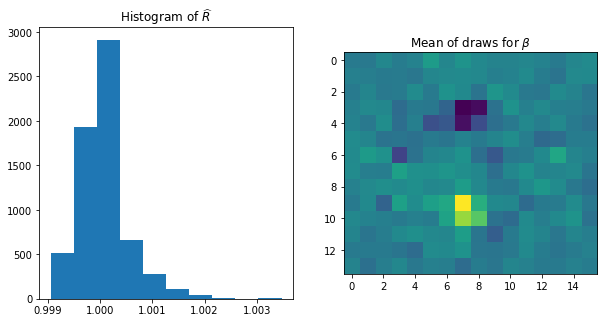

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(summary.loc[:, 'Rhat'])
ax[0].set_title('Histogram of $\widehat{R}$')
mean_beta  = pooled_fit['beta'].mean(axis=0)
ax[1].imshow(mean_beta.reshape(14, 16));
ax[1].set_title(r'Mean of draws for $\beta$');

__3.1.2 Evaluation of model fit with PSIS-loo cross-validation__

In [44]:
log_likelihoods = pooled_fit['log_lik']
# cross validated fit
loo, _, ks = PSIS.psisloo(log_likelihoods)
# raw fit
lppd = np.sum(np.log(np.exp(log_likelihoods).mean(axis=0)))

In [47]:
# Investigate loo-fit and raw fit
loo, np.exp(lppd/3120)

(nan, 0.9993383660411598)

As seen above, we encounter numerical problems evaluating the model fit with the loo-cross validation scheme. To get an idea of the problem and the quality of the fit, we investigate the raw likelihoods instead. 

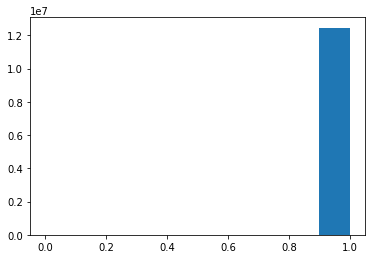

In [22]:
plt.hist(np.exp(log_likelihoods.flatten()));

All the likelihoods are very close to one, this indicates overfitting and is probably the reason for the numerical issues. We discuss this more in the conclusion.

__3.1.3 Predictive Performance__

We evaluate the predictive performance on unseen test data. For the pooled model, we have left out all samples from 3 participants. We now evaluate the perfomance on those. 

In order to do this, we extract all the sampled $\alpha$ and $\beta$ from the model. We then perform the regression as described above, mapping each new image $x_t$ to a probabilitiy via
$$ z = x_t \beta + \alpha$$
and
$$\theta = \text{logit}^{-1}(z).$$

In [12]:
def make_predictions(images, beta, alpha):
    nr_images = images.shape[0]
    nr_samples = beta.shape[0]
    predictions = np.empty((nr_samples, nr_images))
    for i in range(nr_samples):
        predictions[i, :] = alpha[i] + np.matmul(subtracted_means_test, beta[i, :])
    return expit(predictions)

In [13]:
test_predictions = make_predictions(subtracted_means_test, pooled_fit['beta'], pooled_fit['alpha'])

This way, we obtain a distribution over $\theta$ for each image $x_t$. We plot the distribution for the first test image below.

The correct label is: 0


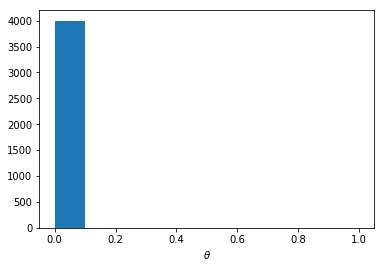

In [14]:
plt.hist(test_predictions[:, 0], range=[0, 1]);
plt.xlabel(r'$\theta$');
print('The correct label is:', test_labels[0])

The distribution is very peaky around 0, which is indeed the true label. Our model makes the correct prediction, and does so with high confidence. To get an overall measure for predictive performance, we compute the mean $\theta$ over all samples for each image. We then make a prediction by simple thresholding the mean $\theta$ at 0.5.

We thereby obtain an a posteriori point estimate that we can compare to the true label. Proceeding this way, we obtain an accuracy of 98.86 %, as can be seen in the cell below.

In [15]:
max_a_posteriori = test_predictions.mean(axis=0).round().astype(int)
print('The test accuracy corresponding to the maximum a posterior estimates is:',
      sum(max_a_posteriori==test_labels)/len(test_labels))

The test accuracy corresponding to the maximum a posterior estimates is: 0.9861111111111112


## 3.2 Hierarchical Model

In the hierarchical model, every participant has their own model, parameterized by $\alpha_p$ and $\beta_p$, while from the same distribution as illustrated below.

<img src="report_images/hierarchical.png" style="width: 300px;"/>

More specifically, we have $\theta$ as the likelihood of "1" as in pooled model, the difference here is that assume every participant has his\her own model. 
$$
     p(y|\theta) = \theta^y (1-\theta)^{1-y}. 
$$ 
$$
z_{ip} = x_{i\in p} \beta_p + \alpha_p.$$

$\beta$ is zero-mean multivariate normal distribution with different variances for different models. For one specific model p, its all dimensions have the identical variance $\sigma_p$.
$$\beta_p \sim N(0,\sigma_p)  $$

And $\alpha_p$ is normal distribution as well, with zero mean and identical variance for all participants.
$$ \alpha_p \sim N(0, \eta)$$


The regression output values $z_p$ are then transferred into probabilities via the inverse logistic transformation

$$ \text{logit}^{-1}: IR \rightarrow (0, 1),  \ \text{logit}^{-1}(z_{ip}) = \frac{e^{z_{ip}}}{1+e^{z_{ip}}},$$ 
yielding 
$$\theta_i = \text{logit}^{-1}(z_{ip}).$$



### 3.2.1 Data processing


In [33]:
train = np.load('new_data/aligned_train.npy')
test = np.load('new_data/aligned_test.npy')
train_labels = np.load('new_data/aligned_labels_train.npy')
test_labels = np.load('new_data/aligned_labels_test.npy')
participant_labels_train = np.load('new_data/participants_labels_train.npy')
participant_labels_test= np.load('new_data/participants_labels_test.npy')
N_tr = train.shape[0]
N_te = test.shape[0]
train_down = train[:,::6,::6].flatten().reshape(N_tr,-1)
test_down = test[:,::6,::6].flatten().reshape(N_te,-1)
train_down = (train_down-np.min(train_down))/(np.max(train_down)-np.min(train_down))
test_down = (test_down-np.min(test_down))/(np.max(test_down)-np.min(test_down))
subtracted_means_train = train_down
subtracted_means_test = test_down

participant_labels_test[participant_labels_test==0] = 26
participant_labels_test[participant_labels_test==1] = 27
participant_labels_test[participant_labels_test==2] = 28
subtracted_means_data = np.vstack((subtracted_means_train,subtracted_means_test))
y_labels = np.vstack((train_labels.reshape(-1,1),test_labels.reshape(-1,1)))
participant_labels = np.vstack((participant_labels_train.reshape(-1,1),participant_labels_test.reshape(-1,1)))
num_pix = train_down.shape[1]
X_tr = np.zeros((100*29,num_pix),dtype=float)
X_te = np.zeros((20*29,num_pix),dtype=float)
Y_tr = np.zeros((100*29,1),dtype=int)
Y_te = np.zeros((20*29,1),dtype=int)
participant_labels_tr = np.zeros((100*29,1),dtype=int)
participant_labels_te = np.zeros((20*29,1),dtype=int)
for i in range(29):
    X_tr[i*100:(i+1)*100,:] = subtracted_means_data[np.where(participant_labels==i)[0][:100],:]
    X_te[i*20:(i+1)*20,:] = subtracted_means_data[np.where(participant_labels==i)[0][100:120],:]
    Y_tr[i*100:(i+1)*100] = y_labels[np.where(participant_labels==i)[0][:100]]
    Y_te[i*20:(i+1)*20] = y_labels[np.where(participant_labels==i)[0][100:120]]
    participant_labels_tr[i*100:(i+1)*100] = participant_labels[np.where(participant_labels==i)[0][:100]]
    participant_labels_te[i*20:(i+1)*20] = participant_labels[np.where(participant_labels==i)[0][100:120]]
print("trainig size", X_tr.shape )
print("test size", X_te.shape )

trainig size (2900, 99)
test size (580, 99)


### 3.2.2 Model

In [15]:
K = X_tr.shape[1]
hierarchical_data_dict = {'y': Y_tr.reshape(len(Y_tr)),
               'x': X_tr,
               'N': len(Y_tr), 
               'K': K , 
               'G': 29,
               'g': participant_labels_tr.reshape(len(Y_tr))+1}

In [ ]:
hierarchical_code = """
data {
    int<lower=0> N;   // number of data items
    int<lower=0> K;   // number of predictors
    int<lower=0> G; // ADDED: number of groups 
    int<lower=1,upper=K> g[N]; // ADDED: group indicator 
    matrix[N, K] x;   // predictor matrix
    int y[N];  // labels
}
parameters {
  real alpha[G];           // group intercepts
  matrix[G, K] beta;       // group coefficients for predictors
  real<lower=0> prior_alpha_cov; // hyperprior:  covariance for prior on intercept
  real<lower=0> prior_beta_cov[G]; //hyperprior: covariance matrix for prior on weights
}

transformed parameters {
    vector[N] z;      // regression outcome vector (inverse logit)
    for (i in 1:N) {
        z[i] = x[i] * beta[g[i]]'  + alpha[g[i]]; }
}

model {
  alpha ~ normal(0, prior_alpha_cov); // prior on the intercept
  for (i in 1:G) {
      beta[i] ~ normal(0, prior_beta_cov[i]); } // prior on the weights
  y ~ bernoulli_logit(z); 
}"""
hierarchical_model = pystan.StanModel(model_code=hierarchical_code)
hierarchical_fit = hierarchical_model.sampling(data=hierarchical_data_dict, iter=2000, chains=4)

In [34]:
model_dict = pickle.load(open("model/model_fit_low_resolution_shuffle.pkl", 'rb'))
hierarchical_fit = model_dict['fit']
mean_beta  = hierarchical_fit['beta'].mean(axis=0)
alpha_mean = hierarchical_fit['alpha'].mean(axis=0)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### 3.2.3 Predictive performance

Every participant has 120 images, we split it into training(100) and test(20) datasets.

The predictive distribution:

$p(y_*|D,x_*) = \int p(y_*| \rho,x_*)p(\rho|D)d\rho \approx \frac{1}{T} \sum_{t=1}^T p(y_*|\rho_t,x_*), \rho_t \sim p(\rho|D) $

Where D is the dataset, $\rho$ represents the parameters.

In [14]:
def make_predictions_ave(images, beta, alpha):
    nr_images = images.shape[0]
    nr_samples = beta.shape[0]
    predictions = np.empty((nr_images,nr_samples))
    for j in range(29):
        sub_test = images[j*20:(j+1)*20]
        predictions[j*20:(j+1)*20,:] = np.matmul(sub_test,beta[:,j, :].T)+ alpha[:,j]
    return expit(predictions)

In [35]:
test_predictions = make_predictions(X_te,mean_beta,alpha_mean)
acc = np.sum(test_predictions.reshape(-1,1).round()==Y_te)/test_predictions.shape[0]
print('MAP accuracy is ',acc)
test_predictions_ = make_predictions_ave(X_te, hierarchical_fit['beta'], hierarchical_fit['alpha'])
acc_ave = np.sum(np.mean(test_predictions_,axis=1).reshape(-1,1).round()==Y_te)/test_predictions_.shape[0]
print('mean accuracy is ',acc_ave)

MAP accuracy is  0.9982758620689656
mean accuracy is  0.9982758620689656


In [37]:
from psis import psisloo
log_likelihoods = hierarchical_fit['log_lik']
loo, _, ks = psisloo(log_likelihoods)
P_eff=np.sum(np.log(np.exp(log_likelihoods).mean(axis=0)))-loo
print("effective number of parameters is ",P_eff)

effective number of parameters is  1242.2669961525967


Text(0.5,0,'k values')

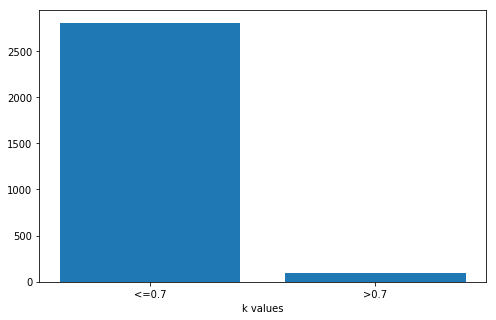

In [38]:
plt.figure(figsize=(8,5))
plt.bar([1,2],[np.sum(ks<=0.7),np.sum(ks>0.7)])
plt.xticks(np.arange(1,3),('<=0.7','>0.7'))
plt.xlabel('k values')

## 3.3 Convolutional Neural Network 
We compare the predictive performance of the statistical models to the one of a simple convolutional neural network. Out architecture has two convolutional layers each followed by a pooling layer, and a fully connected network with one hidden layer as defined below.

In [ ]:
# define CNN
class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=30,kernel_size=4,padding=0,stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,padding=0,stride=1)
        self.conv2 = nn.Conv2d(in_channels=30,out_channels=15,kernel_size=4,padding=0,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,padding=0,stride=1)
        self.num_fea = 15*20*25#20*20,26*26
        self.fc1 = nn.Sequential(nn.Linear(in_features=self.num_fea,out_features=128,bias=True),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(in_features=128,out_features=2,bias=False))
    def forward(self, x):
        conv_x = self.conv1(x)
        activated_x = F.relu(conv_x)
        pooled_x = self.pool1(activated_x)
        conv_x = self.conv2(pooled_x)
        activated_x = F.relu(conv_x)
        pooled_x = self.pool2(activated_x)
        x1 = pooled_x.view(-1,self.num_fea)
        x = self.fc1(x1)
        return F.softmax(x, dim=1), conv_x, activated_x, pooled_x

In [ ]:
# for the sake of demo, we load the trained model directly
cnn = CNN_net()
cnn.load_state_dict(torch.load('model/cnn'))
out,conv_x, activated_x, pooled_x = cnn(torch.from_numpy(test_X))
test_pred = torch.max(out, 1)[1].data.numpy()
acc = np.sum(test_pred==test_label)/N_te
print('test accuracy: ',acc)

In [33]:
cnn = CNN_net()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Here is the learning curve of test data set, the test accuracy stablized around 0.8 after 150 epochs.

<img src="FromJia/test_acc_150lp_fin.png" style="width: 600px;"/> 

We also plot the features from convolutional and pooled layers.

<img src="FromJia/conv_layer.png" style="width: 1000px;"/>

Visualization of convolutional layer

<img src="FromJia/pool_layer.png" style="width: 1000px;"/> 
Visualization of pooled layer

# 4. Conclusion

Both the pooled and the hierarchical model reasonably fit the data.
In the prediction task, both the pooled model and the hierarchical model have a good predictice accuracy (98.61% and 99.8% accuracy, respectively). Due to the different train-test-splits, however, the predictive performance isn't strictly comparable. 
The neural network performs less well.

The models both solve the task to a satisfactory degree, but especially the pooled model seems to exhibit overfitting (likelihoods close to 1), which causes the PSIS-loo cross validation to break down due to numerical reasons. This might be due to the large number of parameters in the regression where we could regularize the model more by forcing the weights closer to zero or by explicitly enforcing sparsity (weights outside the brain should be zero). An alternative approach could be to pre-extract smaller feature vectors, for example with classic feature extraction or machine learning methods.